# Analyzing Austin PD's Crime Reports Dataset

The dataset is available from the Austin Police Department on https://data.austintexas.gov/Public-Safety/Crime-Reports/fdj4-gpfu.


## Table of Contents 

    I. Introduction
    II. Data Scrubbing
    III. Exploratory Analysis 
    
    Questions:
><ul>
><li><a href="#q1"> 1. What areas of Austin have the highest crime rates?</a></li>
><li><a href="#q2"> 2. How is crime distributed in 78701?</a></li> 
><li><a href="#q3"> 3. How is crime distributed in 78753?</a></li>     
><li><a href="#q4"> 4. How is crime distributed in 78741?</a></li>
><li><a href="#q5"> 5. How is crime distributed in 78745?</a></li>
><li><a href="#q6"> 6. How is crime distributed in 78705?</a></li>
><li><a href="#q7"> 7. How are violent crimes, in particular murder, capital murder, armed robbery, aggrivated assault, and rape distributed?
><li><a href="#q8"> 8. How is crime distributed across different districts and sectors around Austin? Location types?
><li><a href="#q9"> 9. How does violent crime appear on the map?
><li><a href="#q10"> 10. Are there any addresses where violent crime and murder occurs frequently?
</a></li>

## I. Introduction

I began reviewing the Crime Reports dataset, provided by the Austin PD, around the same time I began reviewing its Hate Crimes datasets for analysis, at the beginning of 2020. This is a rather large dataset, containing over 2 million records, spanning from 2003 to the present, and is updated weekly. 

This is a self-paced project, conceived outside of both work and the educational arenas. It is my hope that this project will reveal some actionable insights that will benefit the Austin law enforcement community, news outlets, and anyone else interested in gaining knowledge on how best to combat the problem of crime in the Austin area.

I first attempted importing the data into this notebook using Sodapy's Socrata API method but found it lacking. It didn't import the entire dataset, and added several redundant columns. I, therefore, prefer to manually download the entire dataset and re-download each week after it's updated.

In [1]:
# importing necessary libraries and configurations
import folium
from folium import plugins
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

plt.style.use("ggplot")
# plt.style.use("classic")
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# loading the data
df = pd.read_csv("crime_reports.csv")

In [3]:
# examining the dataframe
display(df.info())
display(df.isnull().sum())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300586 entries, 0 to 2300585
Data columns (total 27 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Incident Number              int64  
 1   Highest Offense Description  object 
 2   Highest Offense Code         int64  
 3   Family Violence              object 
 4   Occurred Date Time           object 
 5   Occurred Date                object 
 6   Occurred Time                float64
 7   Report Date Time             object 
 8   Report Date                  object 
 9   Report Time                  float64
 10  Location Type                object 
 11  Address                      object 
 12  Zip Code                     float64
 13  Council District             float64
 14  APD Sector                   object 
 15  APD District                 object 
 16  PRA                          object 
 17  Census Tract                 float64
 18  Clearance Status             object 
 19  

None

Incident Number                      0
Highest Offense Description          0
Highest Offense Code                 0
Family Violence                      0
Occurred Date Time                 165
Occurred Date                        0
Occurred Time                       84
Report Date Time                     1
Report Date                          0
Report Time                          1
Location Type                    20883
Address                             12
Zip Code                         14152
Council District                 47113
APD Sector                        8981
APD District                      9456
PRA                              10718
Census Tract                   1566539
Clearance Status                605972
Clearance Date                  336767
UCR Category                   1515983
Category Description           1515983
X-coordinate                     10138
Y-coordinate                     10138
Latitude                         38855
Longitude                

,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
0,20191571574,FRAUD - OTHER,1199,N,06/03/2019 04:00:00 PM,06/03/2019,1600.0,06/06/2019 05:34:00 PM,06/06/2019,1734.0,DEPARTMENT / DISCOUNT STORE,10817 BALLARD PATH,78717.0,6.0,AD,5,573,203.11,NaN,NaN,NaN,NaN,3097785.0,3097785.0,30.483646,-97.789495,"(30.48364631, -97.7894953)"
1,20191550153,DEADLY CONDUCT,408,N,06/04/2019 03:12:00 AM,06/04/2019,312.0,06/04/2019 03:16:00 AM,06/04/2019,316.0,RESIDENCE / HOME,8312 N IH 35 SVRD SB,78753.0,4.0,ED,1,250,18.06,N,06/06/2019,13A,Aggravated Assault,3128227.0,3128227.0,30.346646,-97.696573,"(30.34664576, -97.69657342)"
2,20195022816,THEFT OF LICENSE PLATE,614,N,06/03/2019 03:00:00 PM,06/03/2019,1500.0,06/04/2019 03:22:00 PM,06/04/2019,1522.0,RESIDENCE / HOME,6312 LIBYAN DR,78745.0,2.0,FR,4,509,24.09,N,06/04/2019,23G,Theft,3098393.0,3098393.0,30.205267,-97.794900,"(30.20526729, -97.79490043)"
3,20205007833,RUNAWAY CHILD,4100,N,02/22/2020 06:00:00 PM,02/22/2020,1800.0,02/24/2020 06:03:00 PM,02/24/2020,1803.0,RESIDENCE / HOME,13012 DEARBONNE DR,78617.0,2.0,HE,7,612,NaN,N,03/03/2020,NaN,NaN,3155456.0,3155456.0,30.176140,-97.615031,"(30.17613952, -97.6150307)"
4,20191671388,BURGLARY OF RESIDENCE,500,N,06/14/2019 12:00:00 PM,06/14/2019,1200.0,06/16/2019 10:00:00 PM,06/16/2019,2200.0,RESIDENCE / HOME,3809 SPICEWOOD SPRINGS RD EB,78731.0,10.0,BA,8,256,17.51,N,09/18/2019,220,Burglary,3111039.0,3111039.0,30.364987,-97.750587,"(30.36498691, -97.75058749)"


,Incident Number,Highest Offense Description,Highest Offense Code,Family Violence,Occurred Date Time,Occurred Date,Occurred Time,Report Date Time,Report Date,Report Time,Location Type,Address,Zip Code,Council District,APD Sector,APD District,PRA,Census Tract,Clearance Status,Clearance Date,UCR Category,Category Description,X-coordinate,Y-coordinate,Latitude,Longitude,Location
2300581,200580964,FAMILY DISTURBANCE/PARENTAL,3458,N,01/08/2005 03:00:00 PM,01/08/2005,1500.0,01/08/2005 03:00:00 PM,01/08/2005,1500.0,RESIDENCE / HOME,5326 BALCONES DR,78731.0,10.0,BA,7,284,NaN,N,02/14/2005,NaN,NaN,3108677.0,3108677.0,30.335507,-97.758866,"(30.33550744, -97.75886595)"
2300582,20061572036,RUNAWAY CHILD,4100,N,06/06/2006 09:56:00 PM,06/06/2006,2156.0,06/06/2006 09:56:00 PM,06/06/2006,2156.0,RESIDENCE / HOME,7203 CHISOS PASS,78724.0,1.0,CH,7,300,NaN,N,06/14/2006,NaN,NaN,3140394.0,3140394.0,30.312960,-97.658924,"(30.31296035, -97.65892399)"
2300583,2005260297,AUTO THEFT,700,N,01/25/2005 09:30:00 PM,01/25/2005,2130.0,01/26/2005 08:35:00 AM,01/26/2005,835.0,PARKING LOTS / GARAGE,1500 FARO DR,78741.0,3.0,HE,3,442,23.18,NaN,03/01/2005,240,Auto Theft,3123697.0,3123697.0,30.234337,-97.713988,"(30.23433705, -97.71398825)"
2300584,20051831398,POSS OF DRUG PARAPHERNALIA,1818,N,07/02/2005 03:33:00 PM,07/02/2005,1533.0,07/02/2005 03:33:00 PM,07/02/2005,1533.0,STREETS / HWY / ROAD / ALLEY,12000 BLOCK N I 35 NB SVC RD,78753.0,1.0,ID,7,222,NaN,NaN,NaN,NaN,NaN,3135416.0,3135416.0,30.385942,-97.672692,"(30.3859424, -97.6726922)"
2300585,20203661753,FAMILY DISTURBANCE,3400,N,12/31/2020 10:49:00 PM,12/31/2020,2249.0,12/31/2020 11:55:00 PM,12/31/2020,2355.0,HOTEL / MOTEL / ETC.,12427 TECH RIDGE BLVD,78753.0,7.0,ED,6,206,NaN,NaN,NaN,NaN,NaN,3137105.0,3137105.0,30.398597,-97.666984,"(30.39859673, -97.66698402)"


## II. Data Prep

There are several columns we don't need which we'll drop. We'll index the data according to the OCCURRED DATE TIME column. The following code creates a reproducible script for scrubbing and parsing the data.

In [4]:
def clean_data(df):
    drop_col = [
        "Incident Number",
        "Occurred Time",
        "Occurred Date Time",
        "Highest Offense Code",
        "Census Tract",
        "PRA",
        "Report Date",
        "Report Time",
        "UCR Category",
        "Category Description",
        "X-coordinate",
        "Y-coordinate",
        "Location",
    ]
    df.drop(drop_col, axis=1, inplace=True)
    df.rename(columns=lambda x: x.strip().lower().replace(" ", "_"), inplace=True)
    fillna = [
        "zip_code",
        "location_type",
        "council_district",
        "apd_district",
        "apd_sector",
    ]
    df[fillna].fillna("N/A", inplace=True)
    date_col = ["occurred_date", "report_date_time", "clearance_date"]
    cat_col = [
        "highest_offense_description",
        "zip_code",
        "location_type",
        "council_district",
        "apd_district",
        "apd_sector",
    ]
    df[date_col] = df[date_col].astype("datetime64")
    df[cat_col] = df[cat_col].astype("category")
    df["year"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.year
    df["month"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.month
    df["week"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.week
    df["day"] = pd.to_datetime(df["occurred_date"], format="%m/%d/%Y").dt.day
    df.set_index(["occurred_date"], inplace=True)
    df.sort_index(inplace=True)
    return df


df = clean_data(df)

In [5]:
# reexamining the dataframe
display(df.info())
display(df.index)
display(df.isnull().sum())
display(df.head())
display(df.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2300586 entries, 2003-01-01 to 2021-01-09
Data columns (total 17 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   highest_offense_description  category      
 1   family_violence              object        
 2   report_date_time             datetime64[ns]
 3   location_type                category      
 4   address                      object        
 5   zip_code                     category      
 6   council_district             category      
 7   apd_sector                   category      
 8   apd_district                 category      
 9   clearance_status             object        
 10  clearance_date               datetime64[ns]
 11  latitude                     float64       
 12  longitude                    float64       
 13  year                         int64         
 14  month                        int64         
 15  week                         int64

None

DatetimeIndex(['2003-01-01', '2003-01-01', '2003-01-01', '2003-01-01',
               '2003-01-01', '2003-01-01', '2003-01-01', '2003-01-01',
               '2003-01-01', '2003-01-01',
               ...
               '2021-01-09', '2021-01-09', '2021-01-09', '2021-01-09',
               '2021-01-09', '2021-01-09', '2021-01-09', '2021-01-09',
               '2021-01-09', '2021-01-09'],
              dtype='datetime64[ns]', name='occurred_date', length=2300586, freq=None)

highest_offense_description         0
family_violence                     0
report_date_time                    1
location_type                   20883
address                            12
zip_code                        14152
council_district                47113
apd_sector                       8981
apd_district                     9456
clearance_status               605972
clearance_date                 336767
latitude                        38855
longitude                       38855
year                                0
month                               0
week                                0
day                                 0
dtype: int64

,highest_offense_description,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,clearance_status,clearance_date,latitude,longitude,year,month,week,day
occurred_date,,,,,,,,,,,,,,,,,
2003-01-01,PUBLIC INTOXICATION,N,2003-01-01 09:12:00,PARKING LOTS / GARAGE,4700 E RIVERSIDE DR,78741.0,3.0,HE,3,C,NaT,30.232898,-97.718807,2003,1,1,1
2003-01-01,IDENTITY THEFT,N,2004-09-29 17:33:00,RESIDENCE / HOME,4402 MOLOKAI DR,78749.0,8.0,DA,7,NaN,2004-12-06,30.210373,-97.847838,2003,1,1,1
2003-01-01,IDENTITY THEFT,N,2012-07-17 19:36:00,RESIDENCE / HOME,5508 MEADOW CREST,78744.0,2.0,FR,6,N,2012-07-21,30.193026,-97.735140,2003,1,1,1
2003-01-01,THEFT,N,2013-07-12 17:15:00,COMMERCIAL / OFFICE BUILDING,6905 WEST GATE BLVD,78745.0,5.0,FR,1,O,2014-11-18,30.206635,-97.815291,2003,1,1,1
2003-01-01,BURGLARY OF VEHICLE,N,2003-01-02 07:00:00,PARKING LOTS / GARAGE,9222 BURNET RD,78758.0,7.0,AD,1,N,NaT,30.376558,-97.726252,2003,1,1,1


,highest_offense_description,family_violence,report_date_time,location_type,address,zip_code,council_district,apd_sector,apd_district,clearance_status,clearance_date,latitude,longitude,year,month,week,day
occurred_date,,,,,,,,,,,,,,,,,
2021-01-09,CRIMINAL MISCHIEF,N,2021-01-09 19:45:00,RESIDENCE / HOME,2304 MONARCH DR,78748.0,5.0,FR,1,NaN,NaT,30.178363,-97.826693,2021,1,1,9
2021-01-09,CRIMINAL MISCHIEF,N,2021-01-09 20:51:00,RESIDENCE / HOME,7601 S CONGRESS AVE,78745.0,2.0,FR,3,NaN,NaT,30.182419,-97.781964,2021,1,1,9
2021-01-09,CRIMINAL MISCHIEF,N,2021-01-09 21:47:00,GOVERNMENT / PUBLIC BUILDING,715 E 8TH ST,78701.0,9.0,GE,2,NaN,NaT,30.267553,-97.734674,2021,1,1,9
2021-01-09,CRIMINAL MISCHIEF,N,2021-01-09 20:37:00,RESIDENCE / HOME,2336 DOUGLAS ST,78741.0,3.0,HE,2,NaN,NaT,30.228235,-97.732948,2021,1,1,9
2021-01-09,CRIMINAL MISCHIEF,N,2021-01-09 18:21:00,OTHER / UNKNOWN,7415 SOUTHWEST PKWY,78735.0,8.0,DA,6,NaN,NaT,30.255958,-97.868255,2021,1,1,9


## III. Exploratory Analysis

<a id='q1'></a>
### A. Question 1. What areas of Austin have the highest crime rates? 

78741.0    206650
78753.0    178839
78701.0    168335
78758.0    159198
78704.0    154567
78745.0    150750
78702.0    136727
78744.0    126255
78723.0    118352
78752.0     84437
78748.0     68091
78759.0     66301
78751.0     64075
78757.0     57888
78705.0     57061
78721.0     47695
78749.0     40415
78724.0     37655
78727.0     35865
78703.0     35173
78731.0     28651
78746.0     28122
78729.0     25274
78750.0     23708
78754.0     22812
Name: zip_code, dtype: int64

78741.0    0.090381
78753.0    0.078217
78701.0    0.073623
78758.0    0.069627
78704.0    0.067602
78745.0    0.065932
78702.0    0.059799
78744.0    0.055219
78723.0    0.051763
78752.0    0.036930
78748.0    0.029780
78759.0    0.028998
78751.0    0.028024
78757.0    0.025318
78705.0    0.024956
78721.0    0.020860
78749.0    0.017676
78724.0    0.016469
78727.0    0.015686
78703.0    0.015383
78731.0    0.012531
78746.0    0.012300
78729.0    0.011054
78750.0    0.010369
78754.0    0.009977
Name: zip_code, dtype: float64

<AxesSubplot:title={'center':'Top 25 zip codes, overall crime (2003-present)'}>

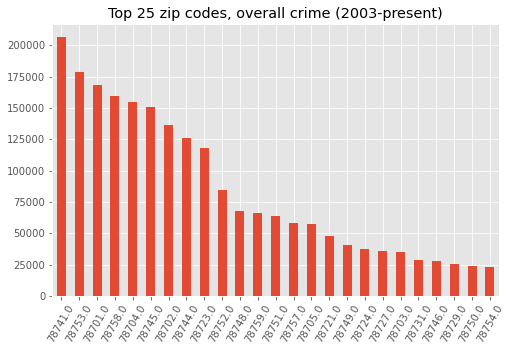

In [6]:
# Create and show dataframe for crime rates by zipcode and as percentages
display(df.zip_code.value_counts().head(25))
display(df.zip_code.value_counts(normalize=True).head(25))

# Visualizing the top 25 areas for crime
df.zip_code.value_counts().head(25).plot.bar(
    title="Top 25 zip codes, overall crime (2003-present)", figsize=(8, 5), rot=60
)

### What are the top 5 crime types in Austin?

In [7]:
df["highest_offense_description"].value_counts().head(5)

BURGLARY OF VEHICLE               231048
THEFT                             211419
FAMILY DISTURBANCE                179083
CRIMINAL MISCHIEF                 127327
ASSAULT W/INJURY-FAM/DATE VIOL     77960
Name: highest_offense_description, dtype: int64

,BURGLARY OF VEHICLE,THEFT,CRIMINAL MISCHIEF,ASSAULT W/INJURY-FAM/DATE VIOL,FAMILY DISTURBANCE,TOTAL
occurred_date,,,,,,
2020-09-30,928,606,504,252,794,3084
2020-10-31,420,613,551,253,881,2718
2020-11-30,481,630,506,282,864,2763
2020-12-31,429,588,472,254,826,2569
2021-01-31,119,112,122,63,182,598


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 217 entries, 2003-01-31 to 2021-01-31
Freq: M
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   BURGLARY OF VEHICLE             217 non-null    int64
 1   THEFT                           217 non-null    int64
 2   CRIMINAL MISCHIEF               217 non-null    int64
 3   ASSAULT W/INJURY-FAM/DATE VIOL  217 non-null    int64
 4   FAMILY DISTURBANCE              217 non-null    int64
 5   TOTAL                           217 non-null    int64
dtypes: int64(6)
memory usage: 11.9 KB


None

<Figure size 432x288 with 0 Axes>

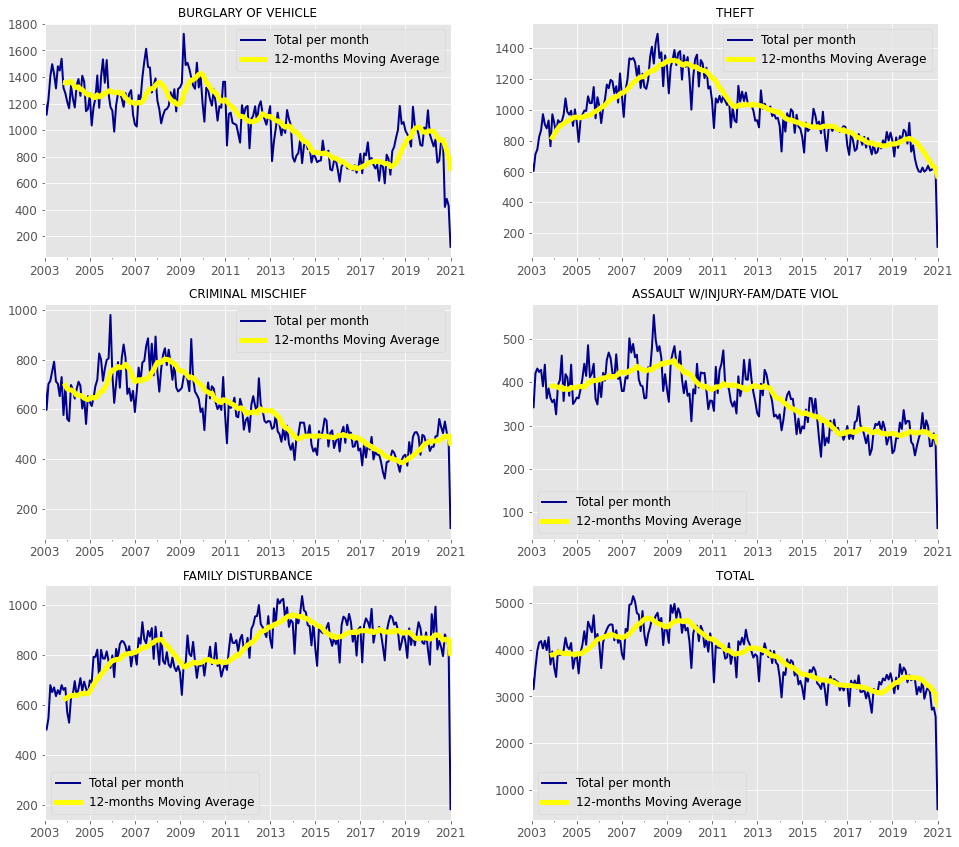

In [25]:
df2 = df.query(
    'highest_offense_description == ["BURGLARY OF VEHICLE", "THEFT", "FAMILY DISTURBANCE", "CRIMINAL MISCHIEF", "ASSAULT W/INJURY-FAM/DATE VIOL"]'
)

monthly = pd.DataFrame(
    df2[df2["highest_offense_description"] == "BURGLARY OF VEHICLE"]
    .resample("M")
    .size()
)
monthly.columns = ["BURGLARY OF VEHICLE"]

for i in df2["highest_offense_description"].unique():
    monthly[i] = pd.DataFrame(
        df2[df2["highest_offense_description"] == i].resample("M").size()
    )

monthly["TOTAL"] = monthly.sum(axis=1)

crimeType = monthly.columns

display(monthly.tail())
display(monthly.info())

plt.figure(1)
plt.figure(figsize=(16, 25))

i = 521
for eachCrime in crimeType:
    plt.subplot(i)
    monthly[eachCrime].plot(color="darkblue", linewidth=2, label="Total per month")
    monthly[eachCrime].rolling(window=12).mean().plot(
        color="yellow", linewidth=5, label="12-months Moving Average"
    )
    plt.title(eachCrime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i = i + 1
plt.show()

<a id='q2'></a>
### B. Question 2. How is crime distributed in 78701 (downtown Austin)? 

PUBLIC INTOXICATION               17152
THEFT                             15754
BURGLARY OF VEHICLE                9258
WARRANT ARREST NON TRAFFIC         8966
DWI                                8309
ASSAULT WITH INJURY                7507
VIOL CITY ORDINANCE - OTHER        6188
POSS OF DRUG PARAPHERNALIA         6033
CRIMINAL MISCHIEF                  5807
CRIMINAL TRESPASS                  3906
POSSESSION OF MARIJUANA            3382
DISTURBANCE - OTHER                3349
CUSTODY ARREST TRAFFIC WARR        2998
POSS CONTROLLED SUB/NARCOTIC       2897
CAMPING IN PARK                    2789
VOCO - ALCOHOL  CONSUMPTION        2690
CRIMINAL TRESPASS/TRANSIENT        2580
ASSAULT BY CONTACT                 2578
THEFT OF BICYCLE                   2506
URINATING IN PUBLIC PLACE          2337
FAMILY DISTURBANCE                 2149
DOC FIGHTING                       2108
PROTECTIVE ORDER                   2101
ASSAULT W/INJURY-FAM/DATE VIOL     1727
Name: highest_offense_description, dtype

PUBLIC INTOXICATION               0.101892
THEFT                             0.093587
BURGLARY OF VEHICLE               0.054997
WARRANT ARREST NON TRAFFIC        0.053263
DWI                               0.049360
ASSAULT WITH INJURY               0.044596
VIOL CITY ORDINANCE - OTHER       0.036760
POSS OF DRUG PARAPHERNALIA        0.035839
CRIMINAL MISCHIEF                 0.034497
CRIMINAL TRESPASS                 0.023204
POSSESSION OF MARIJUANA           0.020091
DISTURBANCE - OTHER               0.019895
CUSTODY ARREST TRAFFIC WARR       0.017810
POSS CONTROLLED SUB/NARCOTIC      0.017210
CAMPING IN PARK                   0.016568
VOCO - ALCOHOL  CONSUMPTION       0.015980
CRIMINAL TRESPASS/TRANSIENT       0.015327
ASSAULT BY CONTACT                0.015315
THEFT OF BICYCLE                  0.014887
URINATING IN PUBLIC PLACE         0.013883
FAMILY DISTURBANCE                0.012766
DOC FIGHTING                      0.012523
PROTECTIVE ORDER                  0.012481
ASSAULT W/I

<AxesSubplot:title={'center':'Crime Distribution (78701)'}, ylabel='highest_offense_description'>

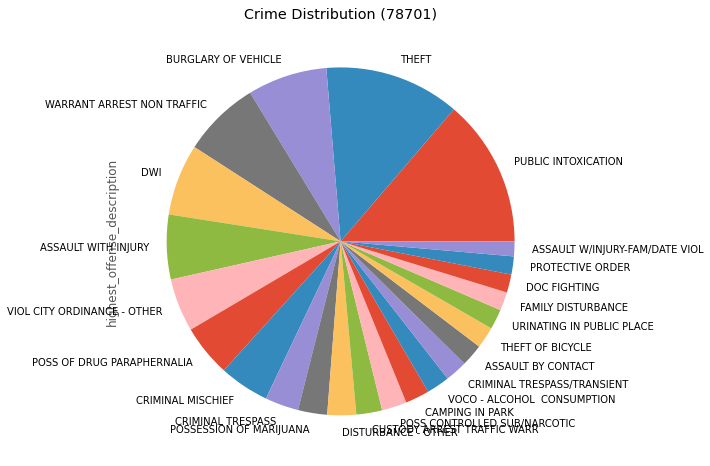

In [9]:
# Examining crime in the 78701 area
df_01 = df[df.zip_code == 78701]

# Create a dataframe for the top crime categories in the zipcode
df_01_off = df_01.highest_offense_description.value_counts().head(24)

# Display the different crime values & then as percentages
display(df_01_off)
display(df_01.highest_offense_description.value_counts(normalize=True).head(24))
df_01_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78701)")

<a id='q3'></a>
### C. Question 2. How is crime distributed in 78753? 

THEFT                             17120
BURGLARY OF VEHICLE               15947
FAMILY DISTURBANCE                14637
CRIMINAL MISCHIEF                  9455
THEFT BY SHOPLIFTING               7632
ASSAULT W/INJURY-FAM/DATE VIOL     7138
BURGLARY OF RESIDENCE              6064
DWI                                4994
DISTURBANCE - OTHER                4749
CUSTODY ARREST TRAFFIC WARR        4348
HARASSMENT                         4243
AUTO THEFT                         4206
POSS OF DRUG PARAPHERNALIA         3723
PUBLIC INTOXICATION                3366
ASSAULT WITH INJURY                3299
CRIMINAL TRESPASS                  3134
POSS CONTROLLED SUB/NARCOTIC       2970
RUNAWAY CHILD                      2931
WARRANT ARREST NON TRAFFIC         2795
POSSESSION OF MARIJUANA            2702
BURGLARY NON RESIDENCE             2501
VIOL CITY ORDINANCE - OTHER        1866
Name: highest_offense_description, dtype: int64

'----------------------------------'

THEFT                             0.095729
BURGLARY OF VEHICLE               0.089170
FAMILY DISTURBANCE                0.081845
CRIMINAL MISCHIEF                 0.052869
THEFT BY SHOPLIFTING              0.042675
ASSAULT W/INJURY-FAM/DATE VIOL    0.039913
BURGLARY OF RESIDENCE             0.033908
DWI                               0.027925
DISTURBANCE - OTHER               0.026555
CUSTODY ARREST TRAFFIC WARR       0.024312
HARASSMENT                        0.023725
AUTO THEFT                        0.023518
POSS OF DRUG PARAPHERNALIA        0.020818
PUBLIC INTOXICATION               0.018821
ASSAULT WITH INJURY               0.018447
CRIMINAL TRESPASS                 0.017524
POSS CONTROLLED SUB/NARCOTIC      0.016607
RUNAWAY CHILD                     0.016389
WARRANT ARREST NON TRAFFIC        0.015629
POSSESSION OF MARIJUANA           0.015109
BURGLARY NON RESIDENCE            0.013985
VIOL CITY ORDINANCE - OTHER       0.010434
Name: highest_offense_description, dtype: float64

<AxesSubplot:title={'center':'Crime Distribution (78753)'}, ylabel='highest_offense_description'>

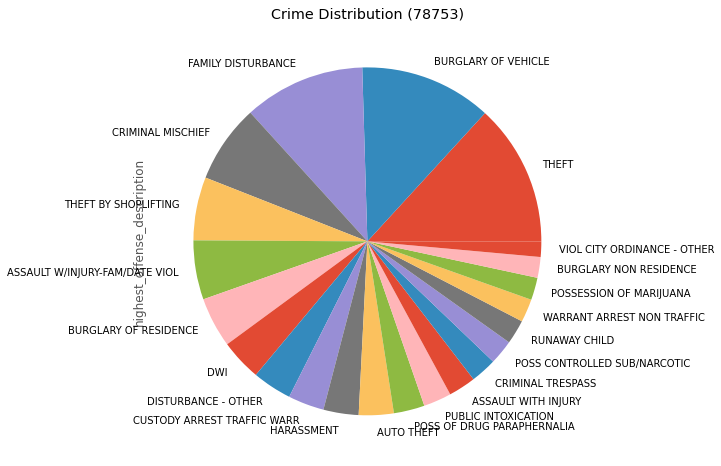

In [10]:
# Examining crime in the 78753 area
df_53 = df[df.zip_code == 78753]

# Create a dataframe for the top 10 crime categories in the zipcode
df_53_off = df_53.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_53_off)
display("----------------------------------")
display(df_53.highest_offense_description.value_counts(normalize=True).head(22))
df_53_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78753)")

<a id='q4'></a>
### D. Question 4. How is crime distributed in 78741 (E Riverside/Oltorf)? 

FAMILY DISTURBANCE                20316
BURGLARY OF VEHICLE               19790
THEFT                             15585
CRIMINAL MISCHIEF                 11029
ASSAULT W/INJURY-FAM/DATE VIOL     9613
BURGLARY OF RESIDENCE              8873
PUBLIC INTOXICATION                6380
CUSTODY ARREST TRAFFIC WARR        6011
DWI                                5652
HARASSMENT                         5505
DISTURBANCE - OTHER                5158
AUTO THEFT                         4612
ASSAULT WITH INJURY                4530
CRIMINAL TRESPASS                  3914
POSS CONTROLLED SUB/NARCOTIC       3853
POSSESSION OF MARIJUANA            3793
THEFT BY SHOPLIFTING               3574
POSS OF DRUG PARAPHERNALIA         3535
WARRANT ARREST NON TRAFFIC         3448
RUNAWAY CHILD                      2789
VIOL CITY ORDINANCE - OTHER        2196
Name: highest_offense_description, dtype: int64

'----------------------------------'

FAMILY DISTURBANCE                0.098311
BURGLARY OF VEHICLE               0.095766
THEFT                             0.075417
CRIMINAL MISCHIEF                 0.053370
ASSAULT W/INJURY-FAM/DATE VIOL    0.046518
BURGLARY OF RESIDENCE             0.042937
PUBLIC INTOXICATION               0.030873
CUSTODY ARREST TRAFFIC WARR       0.029088
DWI                               0.027351
HARASSMENT                        0.026639
DISTURBANCE - OTHER               0.024960
AUTO THEFT                        0.022318
ASSAULT WITH INJURY               0.021921
CRIMINAL TRESPASS                 0.018940
POSS CONTROLLED SUB/NARCOTIC      0.018645
POSSESSION OF MARIJUANA           0.018355
THEFT BY SHOPLIFTING              0.017295
POSS OF DRUG PARAPHERNALIA        0.017106
WARRANT ARREST NON TRAFFIC        0.016685
RUNAWAY CHILD                     0.013496
VIOL CITY ORDINANCE - OTHER       0.010627
Name: highest_offense_description, dtype: float64

<AxesSubplot:title={'center':'Crime Distribution (78741)'}, ylabel='highest_offense_description'>

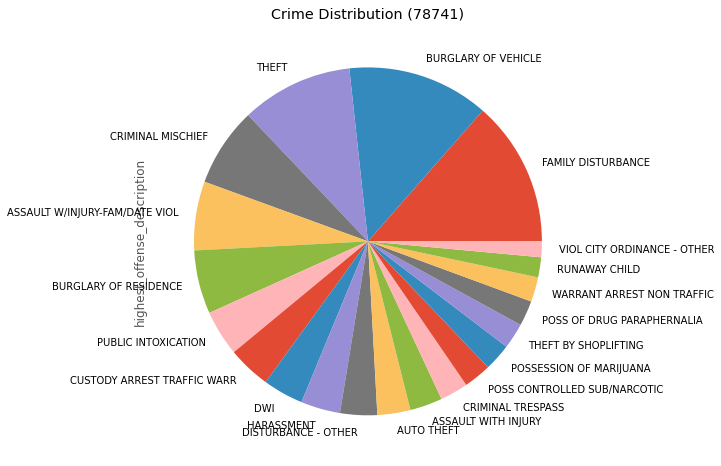

In [11]:
# Examining crime in the 78741 area (the highest amount of crime of any Austin zip code)
df_41 = df[df.zip_code == 78741]

# Create a dataframe for the top crime categories in the zipcode
df_41_off = df_41.highest_offense_description.value_counts().head(21)

# Display the different crime values & then as percentages
display(df_41_off)
display("----------------------------------")
display(df_41.highest_offense_description.value_counts(normalize=True).head(21))
df_41_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78741)")

<a id='q5'></a>
### E. Question 5. How is crime distributed in 78745 (far south Austin)?

FAMILY DISTURBANCE                14907
BURGLARY OF VEHICLE               14752
THEFT                             13546
CRIMINAL MISCHIEF                  8500
BURGLARY OF RESIDENCE              5868
ASSAULT W/INJURY-FAM/DATE VIOL     5749
HARASSMENT                         5133
DISTURBANCE - OTHER                4510
DWI                                4412
PUBLIC INTOXICATION                3995
CUSTODY ARREST TRAFFIC WARR        3248
BURGLARY NON RESIDENCE             2921
AUTO THEFT                         2844
ASSAULT WITH INJURY                2663
RUNAWAY CHILD                      2595
POSSESSION OF MARIJUANA            2587
WARRANT ARREST NON TRAFFIC         2108
POSS CONTROLLED SUB/NARCOTIC       2015
THEFT BY SHOPLIFTING               1979
CRIMINAL TRESPASS                  1952
IDENTITY THEFT                     1575
POSS OF DRUG PARAPHERNALIA         1517
Name: highest_offense_description, dtype: int64

'----------------------------------'

FAMILY DISTURBANCE                0.098886
BURGLARY OF VEHICLE               0.097857
THEFT                             0.089857
CRIMINAL MISCHIEF                 0.056385
BURGLARY OF RESIDENCE             0.038925
ASSAULT W/INJURY-FAM/DATE VIOL    0.038136
HARASSMENT                        0.034050
DISTURBANCE - OTHER               0.029917
DWI                               0.029267
PUBLIC INTOXICATION               0.026501
CUSTODY ARREST TRAFFIC WARR       0.021546
BURGLARY NON RESIDENCE            0.019376
AUTO THEFT                        0.018866
ASSAULT WITH INJURY               0.017665
RUNAWAY CHILD                     0.017214
POSSESSION OF MARIJUANA           0.017161
WARRANT ARREST NON TRAFFIC        0.013983
POSS CONTROLLED SUB/NARCOTIC      0.013367
THEFT BY SHOPLIFTING              0.013128
CRIMINAL TRESPASS                 0.012949
IDENTITY THEFT                    0.010448
POSS OF DRUG PARAPHERNALIA        0.010063
Name: highest_offense_description, dtype: float64

<AxesSubplot:title={'center':'Crime Distribution (78745)'}, ylabel='highest_offense_description'>

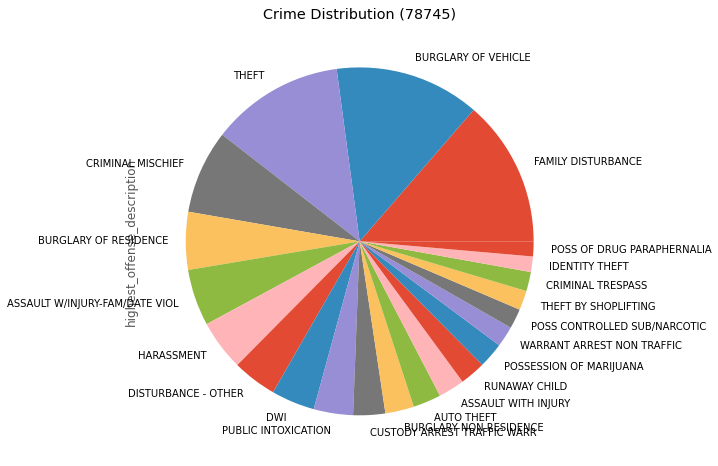

In [12]:
# Examining crime in the 78745 area
df_45 = df[df.zip_code == 78745]

# Create a dataframe for the top 10 crime categories in the zipcode
df_45_off = df_45.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_45_off)
display("----------------------------------")
display(df_45.highest_offense_description.value_counts(normalize=True).head(22))
df_45_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78745)")

<a id='q6'></a>
### F. Question 6. How is crime distributed in 78705 (UT campus area)?

BURGLARY OF VEHICLE               8615
THEFT                             5595
CRIMINAL MISCHIEF                 4962
THEFT OF BICYCLE                  3470
PUBLIC INTOXICATION               2629
BURGLARY OF RESIDENCE             2118
WARRANT ARREST NON TRAFFIC        1549
CRIMINAL TRESPASS                 1342
AUTO THEFT                        1304
ASSAULT WITH INJURY               1245
DWI                               1219
HARASSMENT                        1212
FAMILY DISTURBANCE                1186
DISTURBANCE - OTHER               1114
BURGLARY NON RESIDENCE             878
CRIMINAL TRESPASS/TRANSIENT        868
VIOL CITY ORDINANCE - OTHER        791
CUSTODY ARREST TRAFFIC WARR        783
GRAFFITI                           777
ASSAULT W/INJURY-FAM/DATE VIOL     690
POSSESSION OF MARIJUANA            657
ASSAULT BY CONTACT                 616
Name: highest_offense_description, dtype: int64

'----------------------------------'

BURGLARY OF VEHICLE               0.150979
THEFT                             0.098053
CRIMINAL MISCHIEF                 0.086960
THEFT OF BICYCLE                  0.060812
PUBLIC INTOXICATION               0.046074
BURGLARY OF RESIDENCE             0.037118
WARRANT ARREST NON TRAFFIC        0.027146
CRIMINAL TRESPASS                 0.023519
AUTO THEFT                        0.022853
ASSAULT WITH INJURY               0.021819
DWI                               0.021363
HARASSMENT                        0.021240
FAMILY DISTURBANCE                0.020785
DISTURBANCE - OTHER               0.019523
BURGLARY NON RESIDENCE            0.015387
CRIMINAL TRESPASS/TRANSIENT       0.015212
VIOL CITY ORDINANCE - OTHER       0.013862
CUSTODY ARREST TRAFFIC WARR       0.013722
GRAFFITI                          0.013617
ASSAULT W/INJURY-FAM/DATE VIOL    0.012092
POSSESSION OF MARIJUANA           0.011514
ASSAULT BY CONTACT                0.010795
Name: highest_offense_description, dtype: float64

<AxesSubplot:title={'center':'Crime Distribution (78705)'}, ylabel='highest_offense_description'>

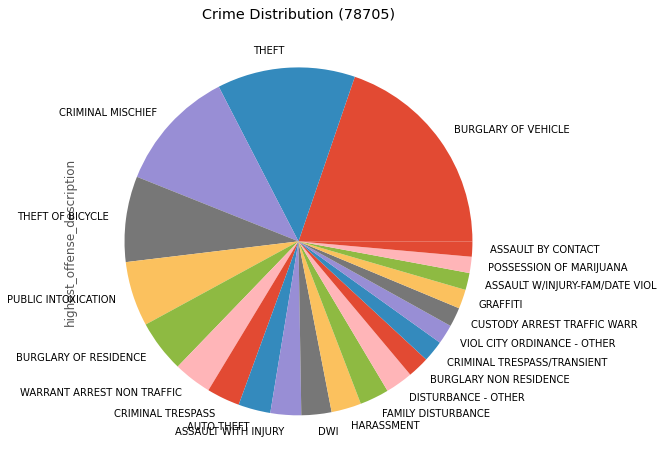

In [13]:
# Examining crime in the 78705 area
df_05 = df[df.zip_code == 78705]

# Create a dataframe for the top 10 crime categories in the zipcode
df_05_off = df_05.highest_offense_description.value_counts().head(22)

# Display the different crime values & then as percentages
display(df_05_off)
display("----------------------------------")
display(df_05.highest_offense_description.value_counts(normalize=True).head(22))
df_05_off.plot.pie(figsize=(8, 8), title="Crime Distribution (78705)")

<a id='q7'></a>
### H. Question 7. How are violent crimes, in particular murder, capital murder, armed robbery, aggrivated assault, and rape distributed? 

In [14]:
# Creating separate dataframes for overall & violent crime
df_viol = df.query(
    'highest_offense_description == ["AGG ASSAULT", "AGG ROBBERY/DEADLY WEAPON", "CAPITAL MURDER", "MURDER", "RAPE"]'
)
df_viol_mur = df.query('highest_offense_description == ["MURDER", "CAPITAL MURDER"]')
df_agg_asslt = df[df.highest_offense_description == "AGG ASSAULT"]
df_agg_robbery = df[df.highest_offense_description == "AGG ROBBERY/DEADLY WEAPON"]

# Creating yearly dataframes
# Annual overall crime
df_17 = df[df.year == 2017]
df_18 = df[df.year == 2018]
df_19 = df[df.year == 2019]
df_20 = df[df.year == 2020]

# Annual violent crime
df_viol_17 = df_viol[df_viol.year == 2017]
df_viol_18 = df_viol[df_viol.year == 2018]
df_viol_19 = df_viol[df_viol.year == 2019]
df_viol_20 = df_viol[df_viol.year == 2020]

# Annual murders
df_viol_mur_17 = df_viol_mur[df_viol_mur.year == 2017]
df_viol_mur_18 = df_viol_mur[df_viol_mur.year == 2018]
df_viol_mur_19 = df_viol_mur[df_viol_mur.year == 2019]
df_viol_mur_20 = df_viol_mur[df_viol_mur.year == 2020]

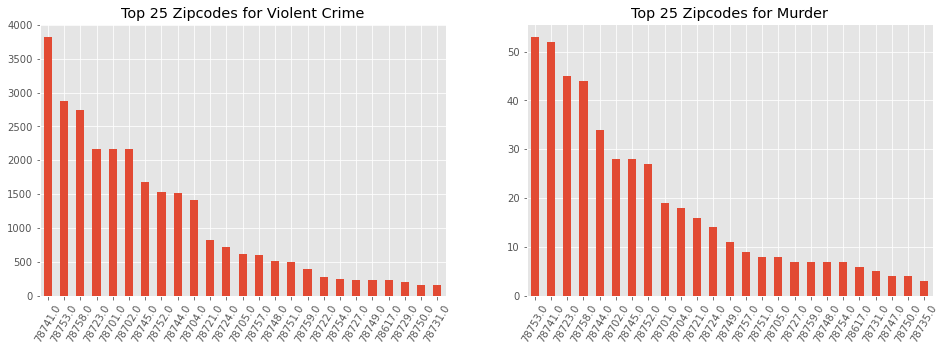

highest_offense_description,AGG ASSAULT,AGG ROBBERY/DEADLY WEAPON,CAPITAL MURDER,MURDER,RAPE
zip_code,,,,,
78610.0,1,0,0,0,0
78613.0,15,11,0,1,6
78617.0,122,62,0,6,37
78621.0,1,0,0,0,0
78634.0,1,0,0,0,0
78652.0,2,0,0,0,0
78653.0,10,3,0,1,1
78660.0,65,28,0,2,17
78664.0,3,0,0,0,0


<Figure size 432x288 with 0 Axes>

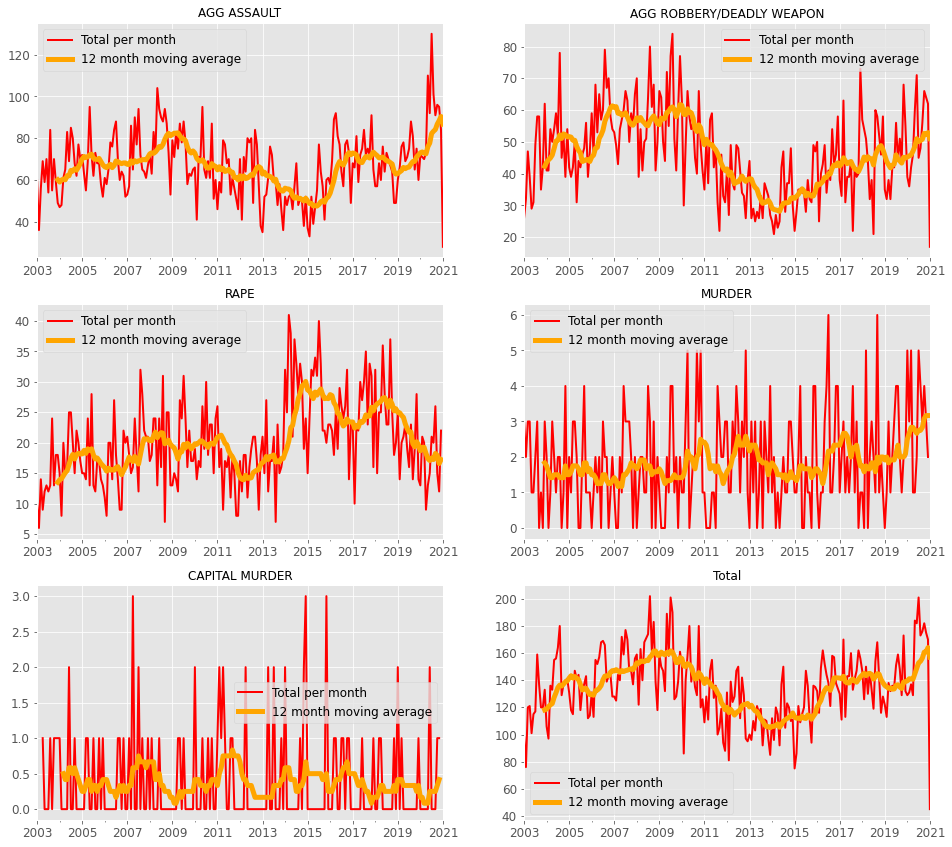

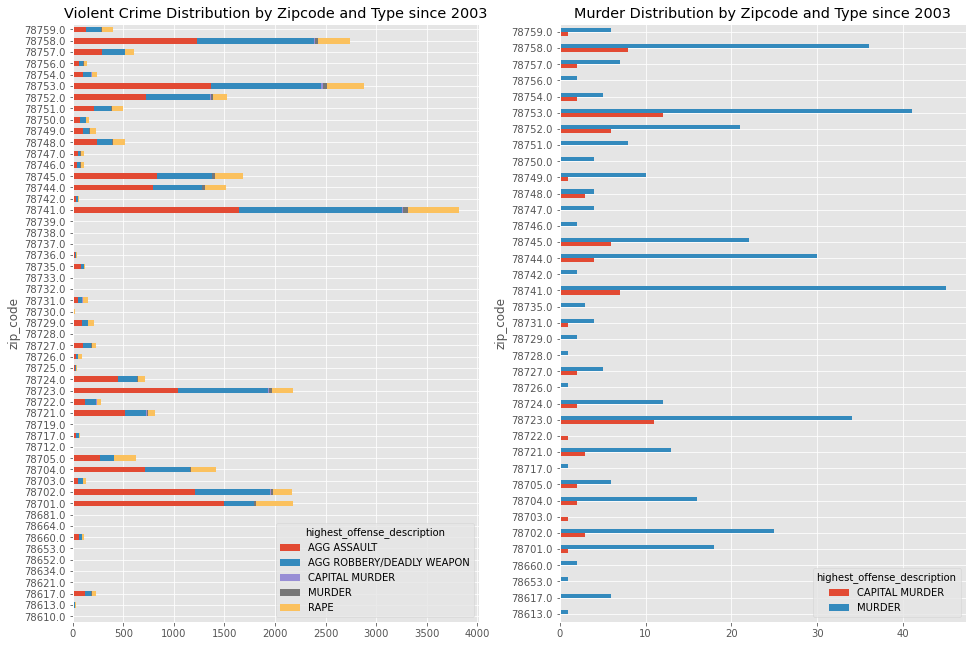

In [33]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=2)
df_viol.zip_code.value_counts().head(25).plot.bar(
    rot=60, title="Top 25 Zipcodes for Violent Crime", ax=axs[0]
)
df_viol_mur.zip_code.value_counts().head(25).plot.bar(
    rot=60, title="Top 25 Zipcodes for Murder", ax=axs[1]
)
plt.show()

viol_freq = pd.crosstab(df_viol.zip_code, df_viol.highest_offense_description)
mur_freq = pd.crosstab(df_viol_mur.zip_code, df_viol_mur.highest_offense_description)
display(viol_freq)

monthly = pd.DataFrame(
    df_viol[df_viol["highest_offense_description"] == "AGG ASSAULT"]
    .resample("M")
    .size()
)
monthly.columns = ["AGG ASSAULT"]

for i in df_viol["highest_offense_description"].unique():
    monthly[i] = pd.DataFrame(
        df_viol[df_viol["highest_offense_description"] == i].resample("M").size()
    )

monthly["Total"] = monthly.sum(axis=1)

crimeTypes = monthly.columns

plt.figure(1)
plt.figure(figsize=(16, 25))

i = 521
for eachCrime in crimeTypes:
    plt.subplot(i)
    monthly[eachCrime].plot(color="red", linewidth=2, label="Total per month")
    monthly[eachCrime].rolling(window=12).mean().plot(
        color="orange", linewidth=5, label="12 month moving average"
    )
    plt.title(eachCrime, fontsize=12)
    plt.xlabel("")
    plt.legend(prop={"size": 12})
    plt.tick_params(labelsize=12)
    i = i + 1

fig, axs = plt.subplots(figsize=(16, 11), ncols=2)
viol_freq.plot.barh(
    title="Violent Crime Distribution by Zipcode and Type since 2003",
    ax=axs[0],
    stacked=True,
)
mur_freq.plot.barh(
    title="Murder Distribution by Zipcode and Type since 2003", ax=axs[1]
)
plt.show()

#### Distribution of violent crime and murders across council districts, APD Districts, and APD sectors 

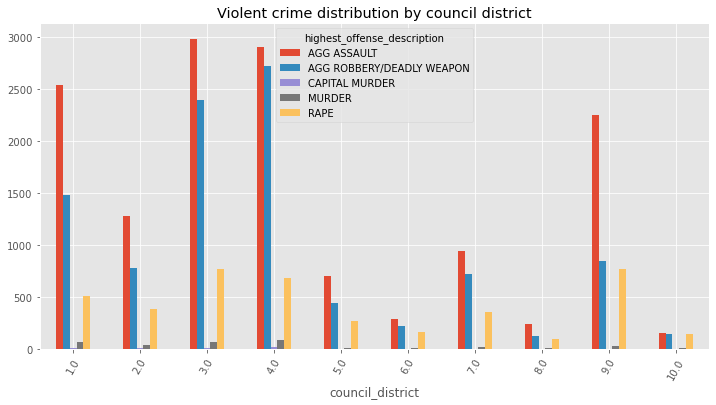

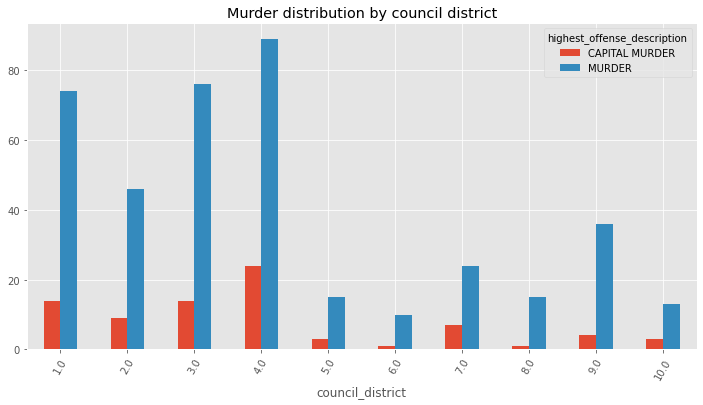

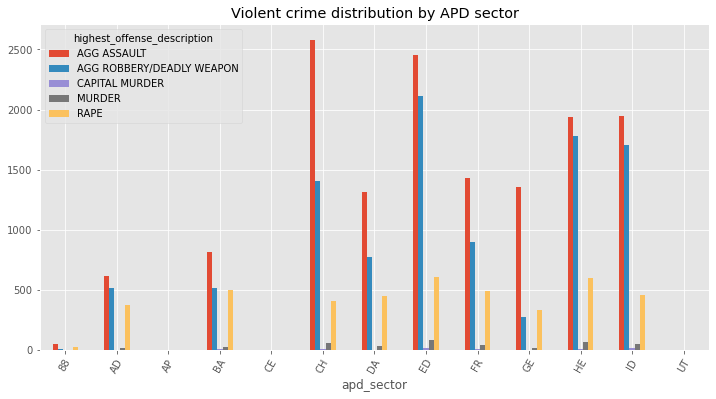

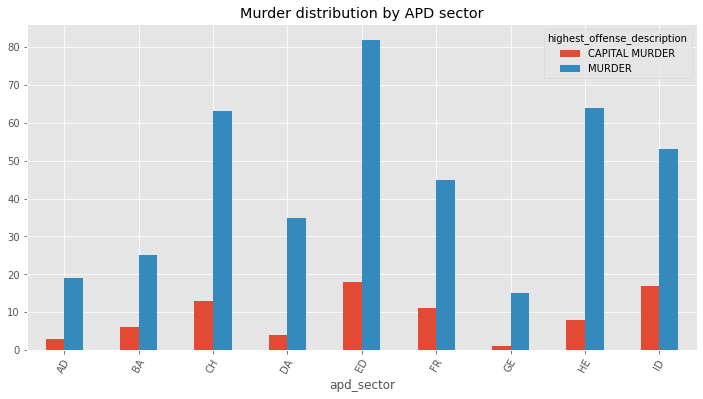

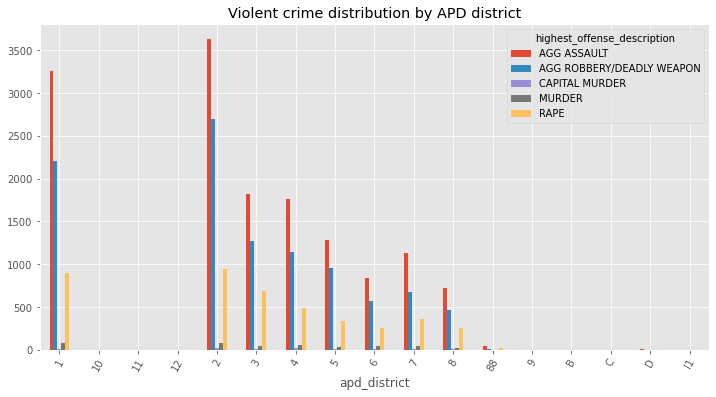

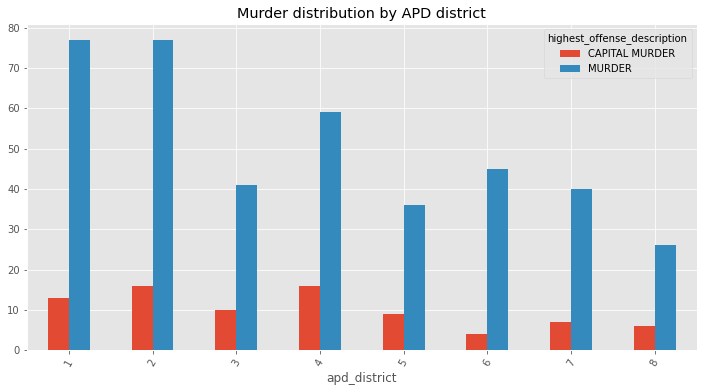

In [16]:
pd.crosstab(df_viol.council_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by council district"
)
plt.show()

pd.crosstab(
    df_viol_mur.council_district, df_viol_mur.highest_offense_description
).plot.bar(figsize=(12, 6), rot=60, title="Murder distribution by council district")
plt.show()

pd.crosstab(df_viol.apd_sector, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by APD sector"
)
plt.show()

pd.crosstab(df_viol_mur.apd_sector, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Murder distribution by APD sector"
)
plt.show()

pd.crosstab(df_viol.apd_district, df_viol.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Violent crime distribution by APD district"
)
plt.show()

pd.crosstab(df_viol_mur.apd_district, df_viol_mur.highest_offense_description).plot.bar(
    figsize=(12, 6), rot=60, title="Murder distribution by APD district"
)
plt.show()

#### Violent crime and murder distribution by location type

highest_offense_description,AGG ASSAULT,AGG ROBBERY/DEADLY WEAPON,CAPITAL MURDER,MURDER,RAPE
location_type,,,,,
ABANDONED/CONDEMNED STRUCTURE,13,7,0,1,4
AMUSEMENT PARK,0,1,0,1,0
ARENA / STADIUM / FAIRGROUNDS / COLISEUM,2,0,0,0,0
ATM SEPARATE FROM BANK,1,2,0,0,0
AUTO DEALERSHIP NEW / USED,10,2,0,0,1
BANKS / SAVINGS & LOAN,5,134,0,1,1
BAR / NIGHT CLUB,654,45,2,7,76
CAMP / CAMPGROUND,20,2,0,0,2
CHURCH / SYNAGOGUE / TEMPLE / MOSQUE,20,5,1,0,7


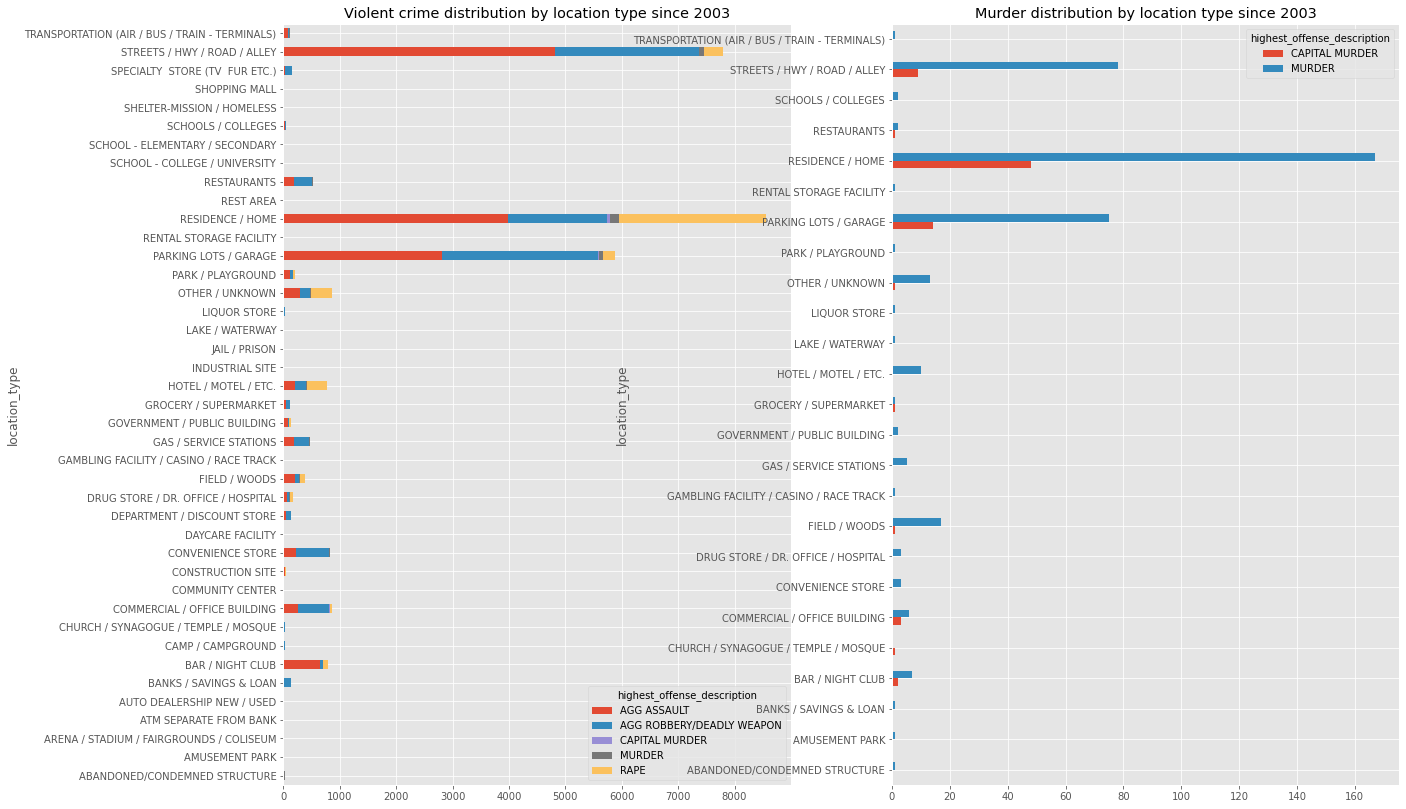

In [17]:
viol_loc = pd.crosstab(df_viol.location_type, df_viol.highest_offense_description)
display(viol_loc)
mur_loc = pd.crosstab(
    df_viol_mur.location_type, df_viol_mur.highest_offense_description
)

fig, axs = plt.subplots(figsize=(20, 14), ncols=2)
viol_loc.plot.barh(
    title="Violent crime distribution by location type since 2003",
    ax=axs[0],
    stacked=True,
)
mur_loc.plot.barh(title="Murder distribution by location type since 2003", ax=axs[1])
plt.show()

<a id='q9'></a>
### I. Question 9. How does violent crime appear on the map?

** Note: Rape incidents provide no location coordinates therefore cannot be shown on a map. **

#### Aggravated assault 

In [18]:
agg_asslt_coords_heat = df_agg_asslt[
    (df_agg_asslt["latitude"].isnull() == False)
    & (df_agg_asslt["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(agg_asslt_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="agg_asslt_heatmap.html")

k

#### Armed robbery 

In [19]:
agg_robbery_coords_heat = df_agg_robbery[
    (df_agg_robbery["latitude"].isnull() == False)
    & (df_agg_robbery["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(
        agg_robbery_coords_heat[["latitude", "longitude"]].values, radius=15
    )
)

k.save(outfile="agg_robbery_heatmap.html")

k

<a id='q8'></a>
#### Murder  

In [20]:
mur_coords_heat = df_viol_mur[
    (df_viol_mur["latitude"].isnull() == False)
    & (df_viol_mur["longitude"].isnull() == False)
]

k = folium.Map(location=[30.2672, -97.7431], tiles="OpenStreetMap", zoom_start=12)

k.add_child(
    plugins.HeatMap(mur_coords_heat[["latitude", "longitude"]].values, radius=15)
)

k.save(outfile="mur_heatmap.html")

k

<a id='q10'></a>
### J. Question 10. Are there any addresses where violent crime and murder occurs frequently?

In [32]:
# Show addresses with 50 or more reported violent crimes
df_viol.address.value_counts().head(13)

500 E 7TH ST                83
9515 N LAMAR BLVD           66
1700 BURTON DR              63
6409 SPRINGDALE RD          59
00 BLOCK UNKNOWN            59
9601 MIDDLE FISKVILLE RD    58
900 BLOCK E 32ND ST         54
1071 CLAYTON LN             53
1030 NORWOOD PARK BLVD      53
9200 NORTH PLZ              53
1137 GUNTER ST              51
2237 E RIVERSIDE DR         51
1124 RUTLAND DR             50
Name: address, dtype: int64

In [30]:
# Show addresses with 2 or more reported murders
df_viol_mur.address.value_counts().head(30)

8800 N IH 35 SVRD SB         3
8610 N LAMAR BLVD            3
6407 SPRINGDALE RD           3
4700 E RIVERSIDE DR          3
6409 SPRINGDALE RD           3
2915 S IH 35 SVRD NB         2
9200 NORTH PLZ               2
833 FAIRFIELD DR             2
2508 E RIVERSIDE DR          2
2501 ANKEN DR                2
8225 SAM RAYBURN DR          2
815 W SLAUGHTER LN           2
1711 RUTLAND DR              2
9010 GALEWOOD DR             2
10503 N LAMAR BLVD           2
2400 WICKERSHAM LN           2
7000 DECKER LN               2
10610 MORADO CIR             2
601 E 15TH ST                2
201 W 5TH ST                 2
1050 SPRINGDALE RD           2
6118 FAIRWAY ST              2
6600 ED BLUESTEIN BLVD SB    2
9601 MIDDLE FISKVILLE RD     2
9220 N IH 35 SVRD SB         2
2713 S CONGRESS AVE          2
605 MASTERSON PASS           2
1137 GUNTER ST               2
8912 N LAMAR BLVD            2
744 W WILLIAM CANNON DR      2
Name: address, dtype: int64

In [23]:
df_clean = df.copy()
df_clean.to_csv("df_clean.csv")

df_17.to_csv("df_17.csv")
df_18.to_csv("df_18.csv")
df_19.to_csv("df_19.csv")
df_20.to_csv("df_20.csv")

df_viol_17.to_csv("df_viol_17.csv")
df_viol_18.to_csv("df_viol_18.csv")
df_viol_19.to_csv("df_viol_19.csv")
df_viol_20.to_csv("df_viol_20.csv")

df_viol_mur_17.to_csv("df_viol_mur_17.csv")
df_viol_mur_18.to_csv("df_viol_mur_18.csv")
df_viol_mur_19.to_csv("df_viol_mur_19.csv")
df_viol_mur_20.to_csv("df_viol_mur_20.csv")

df_viol.to_csv("df_viol.csv")
df_viol_mur.to_csv("df_viol_mur.csv")

df_01.to_csv("df_01.csv")
df_53.to_csv("df_53.csv")
df_41.to_csv("df_41.csv")
df_45.to_csv("df_45.csv")
df_05.to_csv("df_05.csv")